In [5]:
import os
import datetime

import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix

import requests
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from rectools.metrics import MAP, calc_metrics, Recall, NDCG
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel
from rectools.models.popular import PopularModel
from rectools import Columns
from rectools.dataset import Dataset

from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

from lightgbm import LGBMRanker
from xgboost import XGBRanker
from catboost import CatBoostRanker, Pool

import optuna

import pickle

from typing import Callable, Dict, Set, List, Optional, Any, Tuple
import gc
from timeit import Timer

import shap
     

import warnings
warnings.filterwarnings('ignore')

/Users/elizaveta/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
/Users/elizaveta/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:365: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/elizaveta/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:365: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/elizaveta/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:365: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in 

In [6]:
os.environ["OPENBLAS_NUM_THREADS"] = "0"

In [7]:
RANDOM_SEED = 42
K_RECOS = 10

DATA_PATH = "data/kion_train"
RESULTS_PATH = "results/hw6"

# Data 

In [8]:
interactions = pd.read_csv(f'{DATA_PATH}/interactions.csv', parse_dates=["last_watch_dt"])
interactions.rename(
    columns={
        "total_dur": "weight", 
        "last_watch_dt": "datetime"
    }, 
    inplace=True) 

interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

users = pd.read_csv(f'{DATA_PATH}/users.csv')

items = pd.read_csv(f'{DATA_PATH}/items.csv')
items = items.rename(columns = {'id' : 'item_id'})

# Feature proccessing

In [9]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'map@10': MAP(k = 10),
        'recall@10': Recall(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

In [10]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {} 

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)
users.head()

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0
3,721985,3,2,0,0
4,704055,2,4,0,0


In [11]:
items_cat_cols = [
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)
items.head()

,item_id,content_type,release_year,for_kids,age_rating,studios
0,10711,0,2002.0,-1,16.0,-1
1,2508,0,2014.0,-1,16.0,-1
2,10716,0,2011.0,-1,16.0,-1
3,7868,0,2015.0,-1,16.0,-1
4,16268,0,1978.0,-1,12.0,33


In [12]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')
     

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [13]:
ranker_train_size = 0.7
ranker_val_size = 0.15
ranker_test_size = 0.15

In [14]:
ranker_days_count = 30
ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]
     

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=RANDOM_SEED, test_size=ranker_test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=RANDOM_SEED, test_size=ranker_val_size / (ranker_train_size + ranker_val_size)
)
     

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [15]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)


,user_id,item_id,datetime,weight,watched_pct,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


## Add new features

In [16]:
# users age mode for current item
full_base_data = base_models_data.merge(users, on='user_id', how='left')
full_base_data['age'] = full_base_data['age'].astype(float)
age_mode_data = full_base_data.groupby('item_id')['age'].agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(columns={'age': 'user_age_mode'})
full_base_data = full_base_data.merge(age_mode_data, on='item_id', how='left')

# users income mode for current item
full_base_data['income'] = full_base_data['income'].astype(float)
income_mode_data = full_base_data.groupby('item_id')['income'].agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(columns={'income': 'user_income_mode'})
full_base_data = full_base_data.merge(income_mode_data, on='item_id', how='left')

# item's popularity with kids
full_base_data['kids_flg_float'] = full_base_data['kids_flg'].astype(float)
full_base_data['kids_flg_float'] = full_base_data['kids_flg_float'].fillna(-1)
kids_pop_data = full_base_data[
    full_base_data['kids_flg_float'] != -1
].groupby('item_id')['kids_flg_float'].sum() / full_base_data[full_base_data['kids_flg_float'] != -1].groupby('item_id')['kids_flg_float'].count()
full_base_data = full_base_data.merge(kids_pop_data.reset_index().rename(columns={'kids_flg_float': 'kids_pop'}), on='item_id', how='left')

# item's popularity with female/male
full_base_data['sex_float'] = full_base_data['sex'].astype(float)
full_base_data['sex_float'] = full_base_data['sex_float'].fillna(-1)
male_pop_data = full_base_data[
    full_base_data['sex_float'] != -1
].groupby('item_id')['sex_float'].sum() / full_base_data[full_base_data['sex_float'] != -1].groupby('item_id')['sex_float'].count()
full_base_data = full_base_data.merge(male_pop_data.reset_index().rename(columns={'sex_float': 'male_pop'}), on='item_id', how='left')

full_base_data['female_pop'] = 1 - full_base_data['male_pop']

full_base_data = full_base_data.drop(['kids_flg_float', 'sex_float', 'datetime'], axis=1)
     

assert full_base_data.shape[0] == base_models_data.shape[0]

## Join features

In [17]:
for col in full_base_data.columns:
  if isinstance(full_base_data[col].dtype, pd.CategoricalDtype):
    if -1 not in full_base_data[col].cat.categories:
      full_base_data[col] = full_base_data[col].cat.add_categories(-1)
      full_base_data.fillna({col: -1}, inplace=True)
  else:
     full_base_data.fillna({col: -1}, inplace=True)
     

items = pd.merge(
    left=items, 
    right=(
        full_base_data
        [['item_id', 'item_pop', 'item_avg_hist', 'user_age_mode', 'user_income_mode', 'kids_pop', 'male_pop', 'female_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users.drop(['age', 'income', 'kids_flg', 'sex'], axis=1), 
    right=(
        full_base_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop', 'age', 'income', 'kids_flg', 'sex']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)
     

,user_id,user_hist,user_avg_pop,user_last_pop,age,income,kids_flg,sex
0,973171,5.0,19550.800000,93403.0,1.0,4.0,1,1
1,962099,13.0,1329.307692,260.0,0.0,2.0,0,1
2,1047345,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Default features

In [18]:
for col in ['item_pop', 'item_avg_hist', 'male_pop', 'female_pop']:
  default_values_items[col] = full_base_data[col].median()

for col in ['content_type',  'kids_pop']:
  default_values_items[col] = 0

for col in ['for_kids', 'studios', 'user_income_mode', 'user_age_mode']:
  default_values_items[col] = -1
  
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': full_base_data['user_avg_pop'].median(),
    'user_last_pop': full_base_data['user_last_pop'].median(),
}

# Ranker dataset

In [19]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
    how='right'
) -> pd.DataFrame:
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how=how,  
        on=['user_id', 'item_id']
    )
    
    default_values = {
        'knn_score': df['knn_score'].min() - 0.01,
        'knn_rank': df['knn_rank'].max() + 1,
        'lfm_score': df['lfm_score'].min() - 0.01,
        'lfm_rank': df['lfm_rank'].max() + 1,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df
     

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

In [20]:
candidates_df = pd.read_csv(f'{RESULTS_PATH}/knn_candidates.csv').rename(
    columns={'rank': 'knn_rank', 'score': 'knn_score'}
).merge(
    pd.read_csv(f'{RESULTS_PATH}/lfm_candidates.csv').rename(
      columns={'rank': 'lfm_rank', 'score': 'lfm_score'}
    ),
    on=['user_id', 'item_id'],
     how='outer'
)
candidates_df = candidates_df[candidates_df['lfm_rank'] < 31]

candidates_df.head()

,Unnamed: 0,user_id,item_id,knn_score,knn_rank,lfm_score,lfm_rank
0,1.0,1097555,6916,5.766666,1.0,2.838595,23.0
10,28.0,1097554,1151,4.609539,1.0,4.412753,1.0
11,29.0,1097554,4580,4.171267,2.0,3.267209,17.0
20,43.0,1097550,10281,7.134963,1.0,4.601806,1.0
21,44.0,1097548,4151,4.002173,1.0,4.853901,6.0


In [21]:
ranker_train = users_filter(train_users, candidates_df, ranker_data)
ranker_val = users_filter(val_users, candidates_df, ranker_data)
ranker_test = users_filter(test_users, candidates_df, ranker_data)

ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,weight,watched_pct,Unnamed: 0,knn_score,knn_rank,lfm_score,lfm_rank,...,for_kids,age_rating,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop
0,3,142,2021-08-13,5892.0,100.0,NaN,0.725299,11.0,3.830572,9.0,...,-1,16.0,-1,35862.0,15.251464,2.0,2.0,0.366487,0.470470,0.529530
1,3,1132,2021-07-01,0.0,NaN,NaN,0.725299,11.0,3.096919,27.0,...,-1,16.0,-1,9638.0,20.171612,2.0,2.0,0.330906,0.438526,0.561474
2,3,1819,2021-07-01,0.0,NaN,NaN,0.725299,11.0,2.955095,29.0,...,-1,16.0,-1,9792.0,14.719669,1.0,2.0,0.349565,0.594162,0.405838


In [22]:
def print_study_info(study):
  print("Number of finished trials: ", len(study.trials))
  print("Best trial:")
  trials = study.best_trials
  for trial in trials:
    print("  Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
     

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df
     

def add_simple_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df
     

def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f'{name}_score'] = y_pred_scores
    df = df.drop_duplicates(['user_id', 'item_id'], keep='last')
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    mask = ((df['lfm_rank'] < 31) & (df['knn_rank'] < 31)).to_numpy()

    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )

    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 31
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [23]:
ranker_train = add_simple_target(ranker_train)
ranker_val = add_simple_target(ranker_val)
ranker_test = add_simple_target(ranker_test)
     

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,weight,watched_pct,Unnamed: 0,knn_score,knn_rank,lfm_score,lfm_rank,...,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop,target,target_ranker
0,3,142,2021-08-13,5892.0,100.0,NaN,0.725299,11.0,3.830572,9.0,...,-1,35862.0,15.251464,2.0,2.0,0.366487,0.470470,0.529530,1,2
1,3,1132,2021-07-01,0.0,NaN,NaN,0.725299,11.0,3.096919,27.0,...,-1,9638.0,20.171612,2.0,2.0,0.330906,0.438526,0.561474,0,0
2,3,1819,2021-07-01,0.0,NaN,NaN,0.725299,11.0,2.955095,29.0,...,-1,9792.0,14.719669,1.0,2.0,0.349565,0.594162,0.405838,0,0


In [24]:
cols = [
    'knn_score', 'knn_rank', 'lfm_score', 'lfm_rank', 'user_hist', 'user_avg_pop', 'user_last_pop', 'age', 'income', 'kids_flg', 'sex',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'user_age_mode', 'user_income_mode', 'kids_pop', 'male_pop', 'female_pop'
]

cat_cols = ['age', 'income', 'sex', 'kids_flg', 'content_type', 'for_kids', 'studios', 'user_age_mode', 'user_income_mode']
     

for col in ['kids_flg', 'sex', 'content_type', 'for_kids', 'studios']:
  ranker_train[col] = ranker_train[col].astype(int)
  ranker_val[col] = ranker_val[col].astype(int)
  ranker_test[col] = ranker_test[col].astype(int)

# LGBM

In [41]:
def get_lgbm_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

def LGBM_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", low=2000, high=10000, step=200)
    max_depth = trial.suggest_int("max_depth", low=3, high=5, step=1)
    num_leaves = trial.suggest_int("num_leaves", low=(2**max_depth) - 2*max_depth, high=(2**max_depth) - max_depth, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)
    min_child_samples = trial.suggest_int("min_child_samples", low=50, high=100, step=10)

    params = {
        'objective': 'lambdarank', 
        'n_estimators': n_estimators,  
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'min_child_samples': min_child_samples, 
        'learning_rate': learning_rate, 
        'reg_lambda': 1, 
        'colsample_bytree': colsample_bytree,
        'random_state': 42,
        'n_jobs': 4,
        'verbose': 0, 
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_lgbm_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_lgbm_group(ranker_val)],
        'eval_metric': 'ndcg',
        'eval_at': (3, 5, 10),
        'categorical_feature': cat_cols,
        'feature_name': cols,
    }
    listwise_model = LGBMRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['recall@10']
     

In [46]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(LGBM_objective, n_trials=10)

[I 2024-03-12 17:59:57,812] A new study created in memory with name: no-name-4e5373dd-2bd0-4fde-8547-1cd89458b253


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-03-12 18:08:48,297] Trial 0 finished with values: [0.045068730701307, 0.08647068896772339] and parameters: {'n_estimators': 8000, 'max_depth': 3, 'num_leaves': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 90}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-03-12 18:20:09,213] Trial 1 finished with values: [0.043650410988477585, 0.08496676150956776] and parameters: {'n_estimators': 8800, 'max_depth': 4, 'num_leaves': 11, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 100}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-03-12 18:32:33,894] Trial 2 finished with values: [0.044523984102094134, 0.08565678001898873] and parameters: {'n_estimators': 9600, 'max_depth': 4, 'num_leaves': 11, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-03-12 18:43:45,626] Trial 3 finished with values: [0.04534010125866597, 0.0865279075008325] and parameters: {'n_estimators': 9600, 'max_depth': 3, 'num_leaves': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'min_child_samples': 70}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-03-12 18:47:08,504] Trial 4 finished with values: [0.0452585409291693, 0.08632263308047508] and parameters: {'n_estimators': 3000, 'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 50}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-03-12 19:02:10,849] Trial 5 finished with values: [0.0409160645259277, 0.0830815115918053] and parameters: {'n_estimators': 10000, 'max_depth': 5, 'num_leaves': 23, 'learning_rate': 0.3, 'colsample_bytree': 0.7, 'min_child_samples': 100}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-03-12 19:06:24,648] Trial 6 finished with values: [0.04141039343269438, 0.08489632544382585] and parameters: {'n_estimators': 4200, 'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.2, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 70}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-03-12 19:14:11,429] Trial 7 finished with values: [0.045040354758578725, 0.08619502158104686] and parameters: {'n_estimators': 6600, 'max_depth': 4, 'num_leaves': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'min_child_samples': 50}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-03-12 19:30:15,375] Trial 8 finished with values: [0.04223128765136327, 0.08425773745182777] and parameters: {'n_estimators': 8600, 'max_depth': 5, 'num_leaves': 27, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 80}. 


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-03-12 19:46:00,490] Trial 9 finished with values: [0.04092415125450059, 0.08304448118070724] and parameters: {'n_estimators': 9000, 'max_depth': 5, 'num_leaves': 26, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 70}. 


CPU times: user 6h 44min 26s, sys: 1min 17s, total: 6h 45min 43s
Wall time: 1h 46min 2s


In [47]:
print_study_info(study)

Number of finished trials:  10
Best trial:
  Params: 
    n_estimators: 9600
    max_depth: 3
    num_leaves: 5
    learning_rate: 0.1
    colsample_bytree: 0.7
    min_child_samples: 70


In [58]:
params = {
    'objective': 'lambdarank', 
    'n_estimators': 9000, 
    'max_depth': 3, 
    'num_leaves': 5, 
    'min_child_samples': 70,
    'learning_rate': 0.1, 
    'reg_lambda': 1, 
    'colsample_bytree': 0.9, 
    'random_state': 42,
}

fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_lgbm_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_lgbm_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
lgbm_model = LGBMRanker(**params)
lgbm_model.fit(**fit_params)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data poi

LGBMRanker(colsample_bytree=0.9, max_depth=3, min_child_samples=70,
           n_estimators=9000, num_leaves=5, objective='lambdarank',
           random_state=42, reg_lambda=1)

In [59]:
lgbm_model.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('ndcg@3', 0.6975663264559528),
                          ('ndcg@5', 0.7269713138639318),
                          ('ndcg@10', 0.7596159308841464)])})

In [102]:
with open(f'{RESULTS_PATH}/lgbm_ranker.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

In [64]:
y_pred: np.ndarray = lgbm_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'lgbm')
ranker_test.head(3)

,user_id,item_id,datetime,weight,watched_pct,Unnamed: 0,knn_score,knn_rank,lfm_score,lfm_rank,...,target,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank,lgbm_score,lgbm_rank,lgbm_hybrid_score,lgbm_hybrid_rank
25,53,15297,2021-07-01,0.0,NaN,NaN,0.61382,11.0,3.293890,10.0,...,0,0,0.299449,1,0.299449,1,0.299449,1,0.299449,1
2,53,3734,2021-07-30,11529.0,100.0,NaN,0.61382,11.0,3.098832,12.0,...,1,2,0.290630,2,0.290630,2,0.290630,2,0.290630,2
16,53,10440,2021-07-01,0.0,NaN,NaN,0.61382,11.0,3.308235,9.0,...,0,0,0.178140,3,0.178140,3,0.178140,3,0.178140,3


In [67]:
models_metrics = {}
# metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)

,listwise_hybrid
map@10,0.045287
recall@10,0.086608


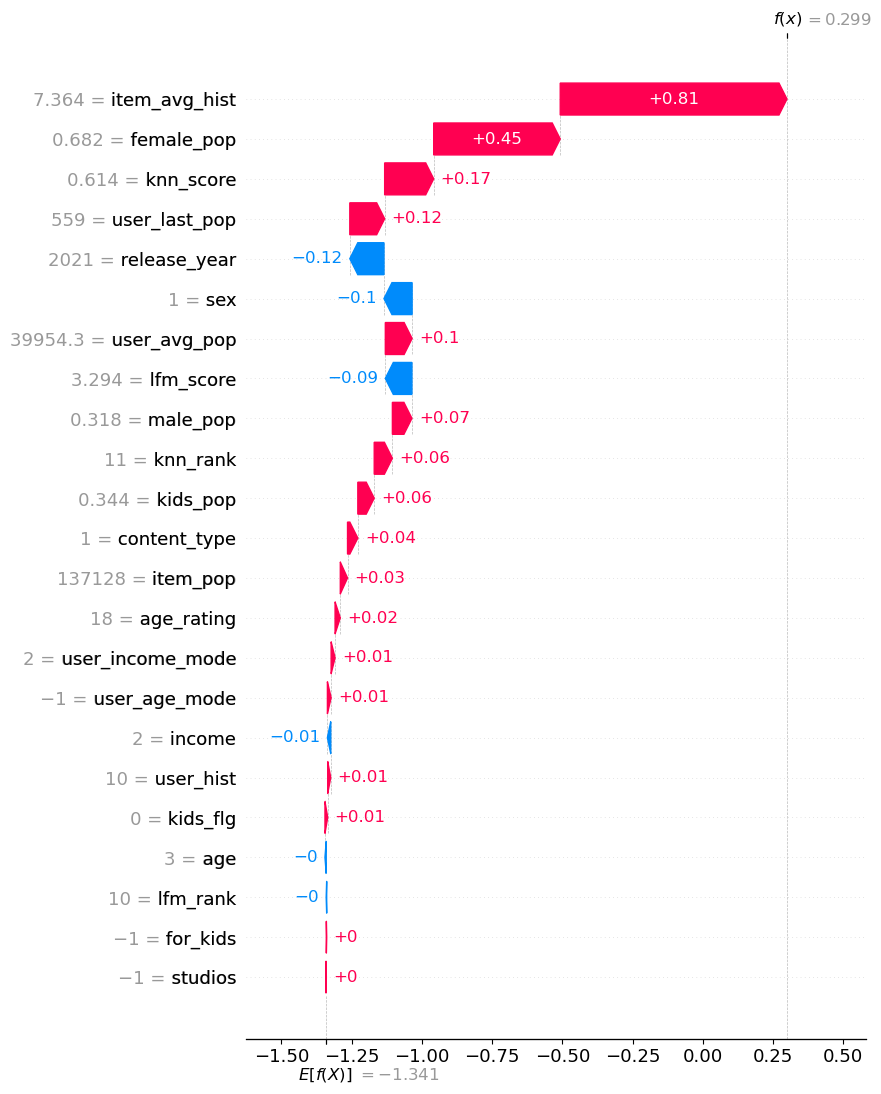

In [68]:
explainer = shap.Explainer(lgbm_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

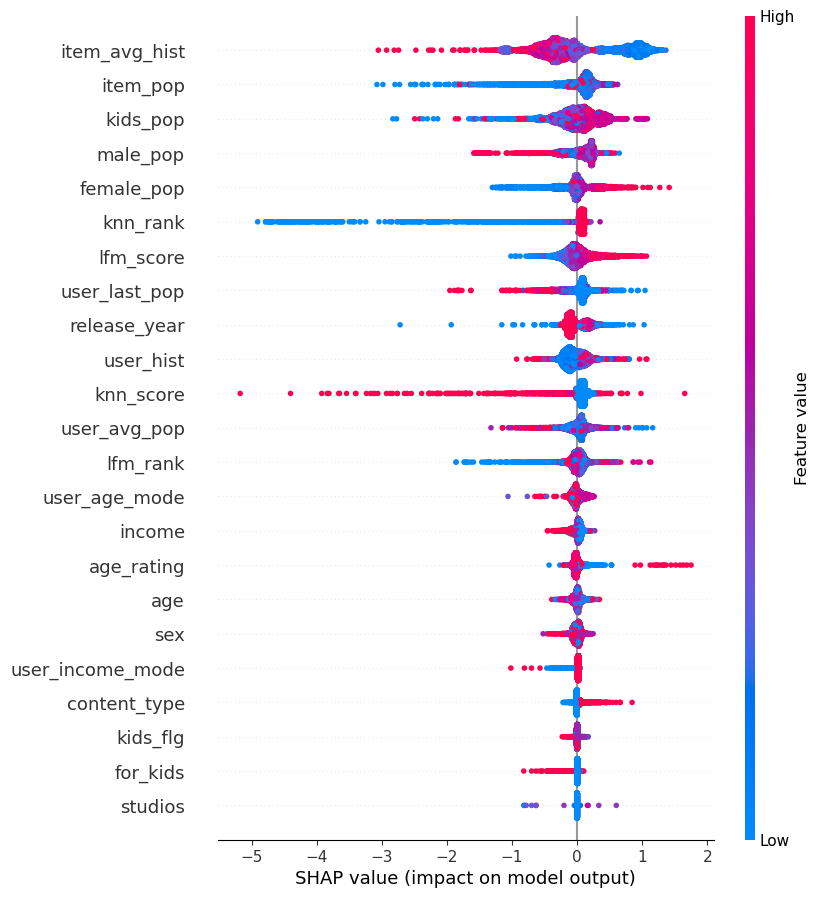

In [69]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

## XGBM

In [70]:
def get_xgb_group(df):
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

In [73]:
def XGBoost_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", low=100, high=200, step=50)
    max_depth = trial.suggest_int("max_depth", low=3, high=5, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)

    params = {
        'objective': 'rank:ndcg', 
        'n_estimators': n_estimators,  
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'reg_lambda': 1,
        'colsample_bytree': colsample_bytree,
        'random_state': RANDOM_SEED,
        'eval_metric': 'ndcg@10',
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_xgb_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_xgb_group(ranker_val)],
        'early_stopping_rounds': early_stopping_rounds,
    }
    listwise_model = XGBRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'xgbm'), 'xgbm_rank')
    return metric_values['map@10'], metric_values['recall@10']

In [74]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(XGBoost_objective, n_trials=5)

[I 2024-03-12 20:17:01,936] A new study created in memory with name: no-name-c1984b76-6b6b-48e4-a959-8913546d99dc
[I 2024-03-12 20:17:38,658] Trial 0 finished with values: [0.04476148501790981, 0.08558367462056798] and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999}. 
[I 2024-03-12 20:18:26,814] Trial 1 finished with values: [0.04487556460098907, 0.08566062952909756] and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999}. 
[I 2024-03-12 20:19:07,620] Trial 2 finished with values: [0.0450428039253288, 0.08601028318306222] and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999}. 
[I 2024-03-12 20:19:35,952] Trial 3 finished with values: [0.043847068162456024, 0.08538956704816349] and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999}. 
[I 2024-03

CPU times: user 21min 42s, sys: 49.5 s, total: 22min 32s
Wall time: 3min 10s


In [79]:
print_study_info(study)

Number of finished trials:  5
Best trial:
  Params: 
    n_estimators: 150
    max_depth: 5
    learning_rate: 0.3
    colsample_bytree: 0.8999999999999999


In [82]:
params = {
  'objective': 'rank:ndcg', 
  'n_estimators': 150,  
  'max_depth': 5,
  'learning_rate': 0.3,
  'reg_lambda': 1,
  'colsample_bytree': 0.9,
  'random_state': RANDOM_SEED,
  'eval_metric': 'ndcg@10',
}

fit_params = {
  'X': ranker_train[cols],
  'y': ranker_train['target_ranker'],
  'group': get_xgb_group(ranker_train),
  'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
  'eval_group': [get_xgb_group(ranker_val)],
}
xgbm_model = XGBRanker(**params)
xgbm_model.fit(**fit_params)

y_pred = xgbm_model.predict(ranker_test[cols])
metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'xgbm'), 'xgbm_rank')

In [101]:
with open(f'{RESULTS_PATH}/xgb_ranker.pkl', 'wb') as f:
    pickle.dump(xgbm_model, f)

In [88]:
ranker_test = add_score_and_rank(ranker_test, y_pred, 'xgbm')

In [89]:
models_metrics = {}
models_metrics['xgbm'] = calc_metrics_(ranker_test, 'xgbm_rank')
pd.DataFrame(models_metrics)[['xgbm']]

,xgbm
map@10,0.045043
recall@10,0.086010


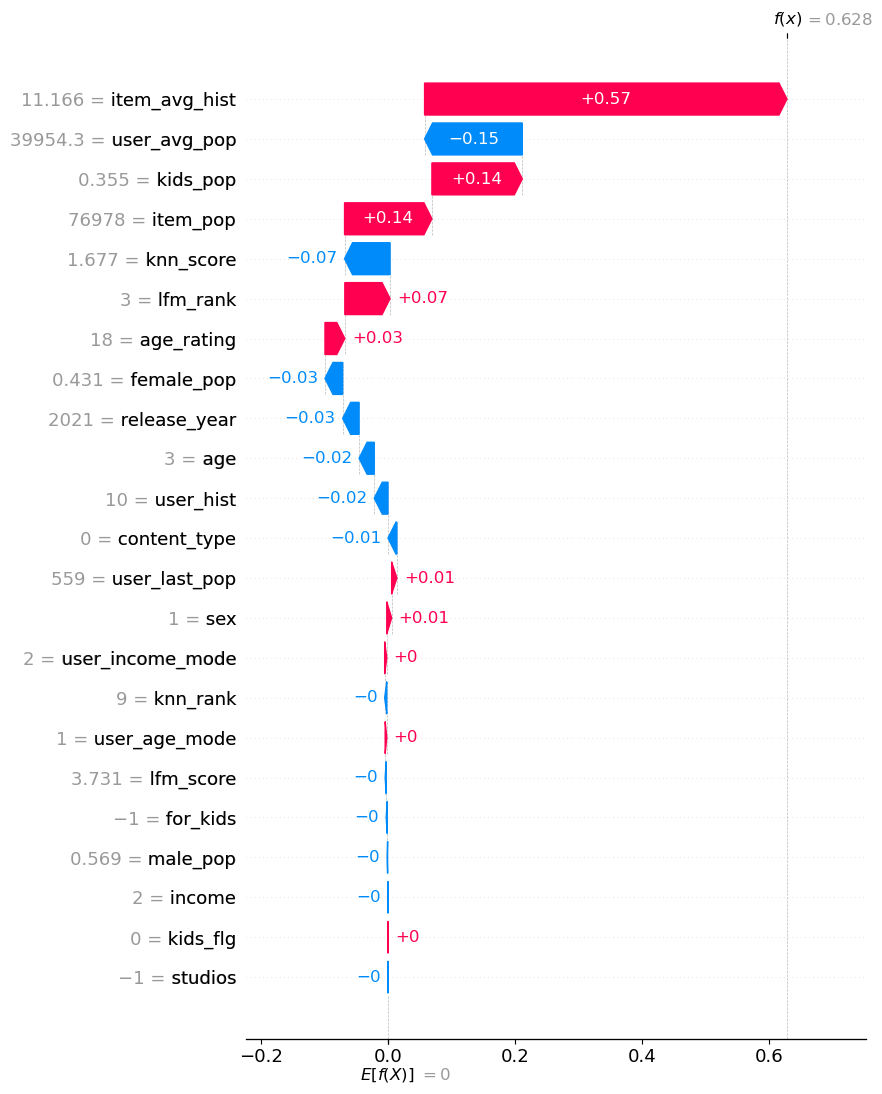

In [90]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

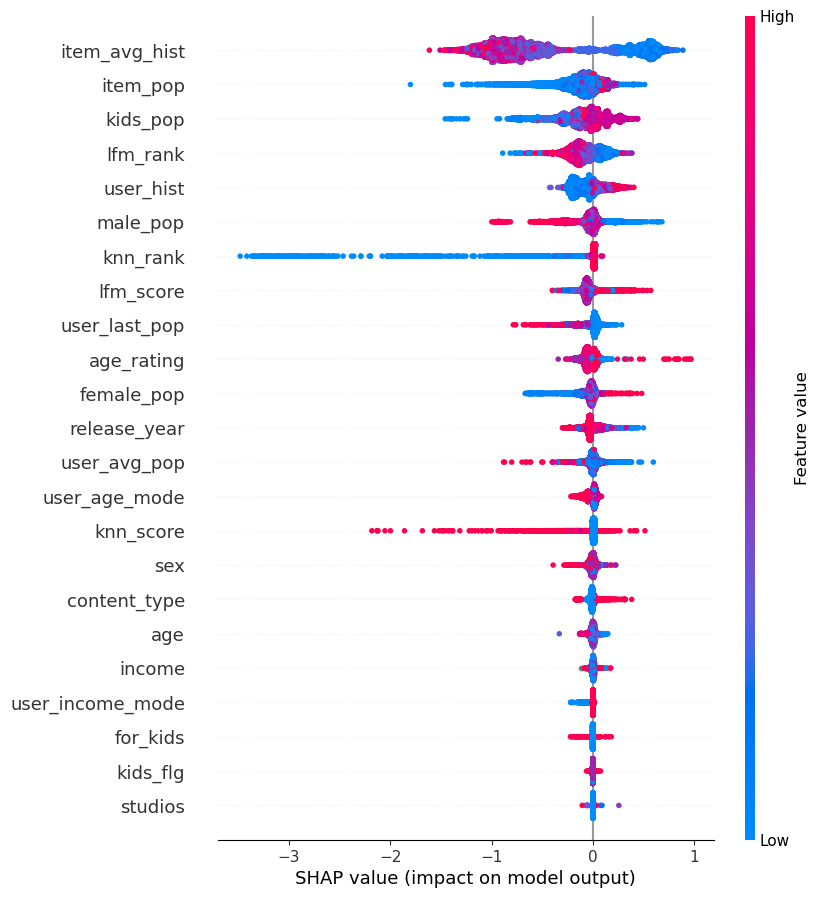

In [91]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

## Catboost

In [94]:
def CatBoost_objective(trial):
    iterations = trial.suggest_int("iterations", low=100, high=200, step=50)
    depth = trial.suggest_int("depth", low=3, high=5, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", low=0.1, high=1, step=0.1)

    early_stopping_rounds = 32

    train_pool = Pool(
        data=ranker_train[cols],
        label=ranker_train['target_ranker'],
        group_id=ranker_train['user_id'].values
    )
    test_pool = Pool(
        data=ranker_val[cols],
        label=ranker_val['target_ranker'],
        group_id=ranker_val['user_id'].values
    )

    params = {
        'iterations': iterations,
        'depth': depth,
        'learning_rate': learning_rate,
        'reg_lambda': reg_lambda, 
        'random_seed': RANDOM_SEED,
        'custom_metric': ['NDCG:top=10'],
        'verbose': 1,
    }

    fit_params = {
        'X': train_pool,
        'eval_set': test_pool,
        'early_stopping_rounds': early_stopping_rounds,
        'plot': 1,
    }
    listwise_model = CatBoostRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'catboost'), 'catboost_rank')
    return metric_values['map@10'], metric_values['recall@10']

In [95]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(CatBoost_objective, n_trials=5)

[I 2024-03-12 20:42:31,866] A new study created in memory with name: no-name-f2978ae3-19c2-4faa-be4c-6b66a4859758


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6983649	best: 0.6983649 (0)	total: 1.08s	remaining: 1m 47s
1:	test: 0.7126130	best: 0.7126130 (1)	total: 1.96s	remaining: 1m 35s
2:	test: 0.7320766	best: 0.7320766 (2)	total: 2.79s	remaining: 1m 30s
3:	test: 0.7397846	best: 0.7397846 (3)	total: 3.63s	remaining: 1m 27s
4:	test: 0.7406897	best: 0.7406897 (4)	total: 4.46s	remaining: 1m 24s
5:	test: 0.7410349	best: 0.7410349 (5)	total: 5.32s	remaining: 1m 23s
6:	test: 0.7411126	best: 0.7411126 (6)	total: 6.16s	remaining: 1m 21s
7:	test: 0.7413345	best: 0.7413345 (7)	total: 6.97s	remaining: 1m 20s
8:	test: 0.7664823	best: 0.7664823 (8)	total: 7.81s	remaining: 1m 18s
9:	test: 0.7677523	best: 0.7677523 (9)	total: 8.63s	remaining: 1m 17s
10:	test: 0.7682396	best: 0.7682396 (10)	total: 9.51s	remaining: 1m 16s
11:	test: 0.7684649	best: 0.7684649 (11)	total: 10.3s	remaining: 1m 15s
12:	test: 0.7692901	best: 0.7692901 (12)	total: 11.2s	remaining: 1m 14s
13:	test: 0.7693605	best: 0.7693605 (13)	total: 12s	remaining: 1m 13s
14:	test: 0.76

[I 2024-03-12 20:43:59,212] Trial 0 finished with values: [0.04401733730063306, 0.08515514716681115] and parameters: {'iterations': 100, 'depth': 5, 'learning_rate': 0.1, 'reg_lambda': 0.8}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6983649	best: 0.6983649 (0)	total: 1.04s	remaining: 2m 35s
1:	test: 0.7147172	best: 0.7147172 (1)	total: 1.92s	remaining: 2m 22s
2:	test: 0.7351086	best: 0.7351086 (2)	total: 2.77s	remaining: 2m 15s
3:	test: 0.7647958	best: 0.7647958 (3)	total: 3.63s	remaining: 2m 12s
4:	test: 0.7686426	best: 0.7686426 (4)	total: 4.44s	remaining: 2m 8s
5:	test: 0.7769226	best: 0.7769226 (5)	total: 5.26s	remaining: 2m 6s
6:	test: 0.7772113	best: 0.7772113 (6)	total: 6.09s	remaining: 2m 4s
7:	test: 0.7801084	best: 0.7801084 (7)	total: 6.96s	remaining: 2m 3s
8:	test: 0.7798075	best: 0.7801084 (7)	total: 7.87s	remaining: 2m 3s
9:	test: 0.7802429	best: 0.7802429 (9)	total: 8.76s	remaining: 2m 2s
10:	test: 0.7804836	best: 0.7804836 (10)	total: 9.58s	remaining: 2m 1s
11:	test: 0.7813306	best: 0.7813306 (11)	total: 10.4s	remaining: 1m 59s
12:	test: 0.7812602	best: 0.7813306 (11)	total: 11.2s	remaining: 1m 58s
13:	test: 0.7808245	best: 0.7813306 (11)	total: 12s	remaining: 1m 56s
14:	test: 0.7810221	b

[I 2024-03-12 20:46:08,410] Trial 1 finished with values: [0.04489512156032688, 0.08600366308409263] and parameters: {'iterations': 150, 'depth': 5, 'learning_rate': 0.3, 'reg_lambda': 0.9}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6983647	best: 0.6983647 (0)	total: 1.02s	remaining: 3m 23s
1:	test: 0.7147236	best: 0.7147236 (1)	total: 1.88s	remaining: 3m 5s
2:	test: 0.7389594	best: 0.7389594 (2)	total: 2.75s	remaining: 3m
3:	test: 0.7667493	best: 0.7667493 (3)	total: 3.64s	remaining: 2m 58s
4:	test: 0.7689040	best: 0.7689040 (4)	total: 4.45s	remaining: 2m 53s
5:	test: 0.7768400	best: 0.7768400 (5)	total: 5.28s	remaining: 2m 50s
6:	test: 0.7772480	best: 0.7772480 (6)	total: 6.19s	remaining: 2m 50s
7:	test: 0.7770028	best: 0.7772480 (6)	total: 7.19s	remaining: 2m 52s
8:	test: 0.7775835	best: 0.7775835 (8)	total: 8.03s	remaining: 2m 50s
9:	test: 0.7781316	best: 0.7781316 (9)	total: 8.83s	remaining: 2m 47s
10:	test: 0.7789473	best: 0.7789473 (10)	total: 9.66s	remaining: 2m 45s
11:	test: 0.7793466	best: 0.7793466 (11)	total: 10.5s	remaining: 2m 44s
12:	test: 0.7793268	best: 0.7793466 (11)	total: 11.3s	remaining: 2m 43s
13:	test: 0.7797597	best: 0.7797597 (13)	total: 12.1s	remaining: 2m 41s
14:	test: 0.77981

[I 2024-03-12 20:49:00,905] Trial 2 finished with values: [0.04510527400631829, 0.08620652152894806] and parameters: {'iterations': 200, 'depth': 5, 'learning_rate': 0.3, 'reg_lambda': 0.2}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6972661	best: 0.6972661 (0)	total: 1.03s	remaining: 2m 33s
1:	test: 0.7109008	best: 0.7109008 (1)	total: 1.89s	remaining: 2m 20s
2:	test: 0.7123560	best: 0.7123560 (2)	total: 2.74s	remaining: 2m 14s
3:	test: 0.7142282	best: 0.7142282 (3)	total: 3.6s	remaining: 2m 11s
4:	test: 0.7164182	best: 0.7164182 (4)	total: 4.43s	remaining: 2m 8s
5:	test: 0.7329784	best: 0.7329784 (5)	total: 5.24s	remaining: 2m 5s
6:	test: 0.7390440	best: 0.7390440 (6)	total: 6.05s	remaining: 2m 3s
7:	test: 0.7401388	best: 0.7401388 (7)	total: 6.87s	remaining: 2m 2s
8:	test: 0.7398861	best: 0.7401388 (7)	total: 7.68s	remaining: 2m
9:	test: 0.7375395	best: 0.7401388 (7)	total: 8.49s	remaining: 1m 58s
10:	test: 0.7398498	best: 0.7401388 (7)	total: 9.38s	remaining: 1m 58s
11:	test: 0.7406139	best: 0.7406139 (11)	total: 10.3s	remaining: 1m 58s
12:	test: 0.7408823	best: 0.7408823 (12)	total: 11.1s	remaining: 1m 57s
13:	test: 0.7654380	best: 0.7654380 (13)	total: 12s	remaining: 1m 56s
14:	test: 0.7655198	best

[I 2024-03-12 20:51:10,072] Trial 3 finished with values: [0.04397589861362929, 0.08518505633057352] and parameters: {'iterations': 150, 'depth': 4, 'learning_rate': 0.1, 'reg_lambda': 0.1}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6867152	best: 0.6867152 (0)	total: 1.02s	remaining: 3m 23s
1:	test: 0.6874577	best: 0.6874577 (1)	total: 1.85s	remaining: 3m 3s
2:	test: 0.6892813	best: 0.6892813 (2)	total: 2.65s	remaining: 2m 54s
3:	test: 0.7000815	best: 0.7000815 (3)	total: 3.51s	remaining: 2m 52s
4:	test: 0.7006434	best: 0.7006434 (4)	total: 4.31s	remaining: 2m 48s
5:	test: 0.7006274	best: 0.7006434 (4)	total: 5.11s	remaining: 2m 45s
6:	test: 0.7234194	best: 0.7234194 (6)	total: 5.9s	remaining: 2m 42s
7:	test: 0.7264528	best: 0.7264528 (7)	total: 6.7s	remaining: 2m 40s
8:	test: 0.7279452	best: 0.7279452 (8)	total: 7.49s	remaining: 2m 38s
9:	test: 0.7377027	best: 0.7377027 (9)	total: 8.34s	remaining: 2m 38s
10:	test: 0.7377591	best: 0.7377591 (10)	total: 9.24s	remaining: 2m 38s
11:	test: 0.7385976	best: 0.7385976 (11)	total: 10s	remaining: 2m 37s
12:	test: 0.7386181	best: 0.7386181 (12)	total: 10.8s	remaining: 2m 35s
13:	test: 0.7404646	best: 0.7404646 (13)	total: 11.7s	remaining: 2m 34s
14:	test: 0.76473

[I 2024-03-12 20:53:56,004] Trial 4 finished with values: [0.04351091289878678, 0.08534768641261638] and parameters: {'iterations': 200, 'depth': 3, 'learning_rate': 0.1, 'reg_lambda': 0.9}. 


CPU times: user 1h 8min 43s, sys: 3min 53s, total: 1h 12min 37s
Wall time: 11min 24s


In [96]:
print_study_info(study)

Number of finished trials:  5
Best trial:
  Params: 
    iterations: 200
    depth: 5
    learning_rate: 0.3
    reg_lambda: 0.2


In [99]:
params = {
  'iterations': 200,
  'depth': 5,
  'learning_rate': 0.3,
  'reg_lambda': 0.2, 
  'random_seed': RANDOM_SEED,
  'custom_metric': ['NDCG:top=10'],
}

train_pool = Pool(
  data=ranker_train[cols],
  label=ranker_train['target_ranker'],
  group_id=ranker_train['user_id'].values
)
test_pool = Pool(
  data=ranker_val[cols],
  label=ranker_val['target_ranker'],
  group_id=ranker_val['user_id'].values
)

fit_params = {
  'X': train_pool,
  'eval_set': test_pool,
  'plot': 1,
}
catboost_model = CatBoostRanker(**params)
catboost_model.fit(**fit_params)

y_pred = catboost_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'catboost')
metric_values = calc_metrics_(ranker_test, 'catboost_rank')
metric_values

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6983647	best: 0.6983647 (0)	total: 1s	remaining: 3m 20s
1:	test: 0.7147236	best: 0.7147236 (1)	total: 1.98s	remaining: 3m 15s
2:	test: 0.7389594	best: 0.7389594 (2)	total: 2.85s	remaining: 3m 7s
3:	test: 0.7667493	best: 0.7667493 (3)	total: 3.74s	remaining: 3m 3s
4:	test: 0.7689040	best: 0.7689040 (4)	total: 4.61s	remaining: 2m 59s
5:	test: 0.7768400	best: 0.7768400 (5)	total: 5.45s	remaining: 2m 56s
6:	test: 0.7772480	best: 0.7772480 (6)	total: 6.4s	remaining: 2m 56s
7:	test: 0.7770028	best: 0.7772480 (6)	total: 7.31s	remaining: 2m 55s
8:	test: 0.7775835	best: 0.7775835 (8)	total: 8.17s	remaining: 2m 53s
9:	test: 0.7781316	best: 0.7781316 (9)	total: 9.01s	remaining: 2m 51s
10:	test: 0.7789473	best: 0.7789473 (10)	total: 9.84s	remaining: 2m 49s
11:	test: 0.7793466	best: 0.7793466 (11)	total: 10.7s	remaining: 2m 47s
12:	test: 0.7793268	best: 0.7793466 (11)	total: 11.5s	remaining: 2m 45s
13:	test: 0.7797597	best: 0.7797597 (13)	total: 12.3s	remaining: 2m 43s
14:	test: 0.779813

{'recall@10': 0.08620652152894806, 'map@10': 0.04510527400631829}

In [100]:
with open(f'{RESULTS_PATH}/catboost_ranker.pkl', 'wb') as f:
    pickle.dump(catboost_model, f)

In [103]:
metric_values

{'recall@10': 0.08620652152894806, 'map@10': 0.04510527400631829}

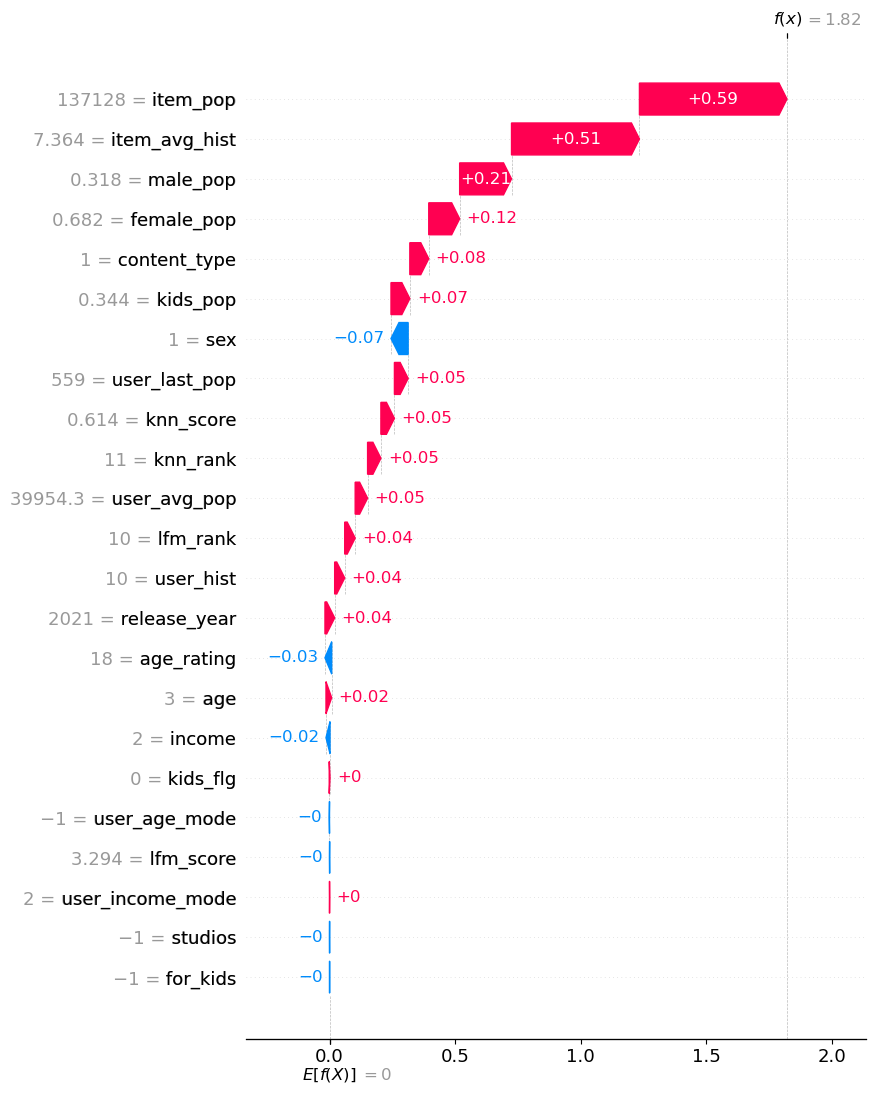

In [106]:
explainer = shap.Explainer(catboost_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

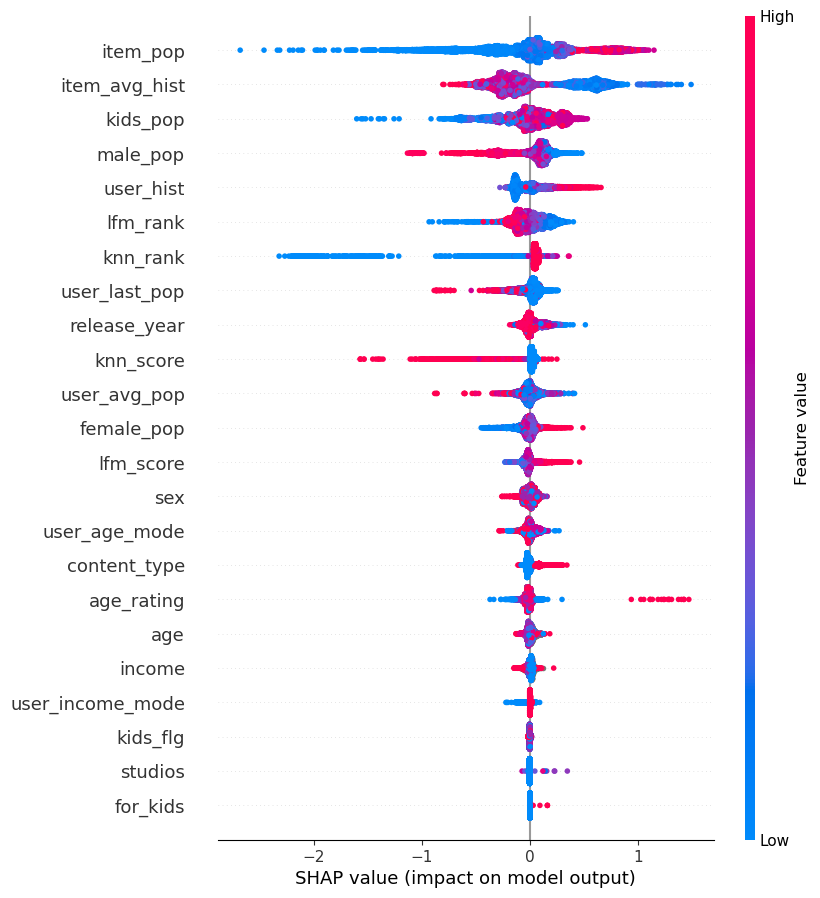

In [107]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [112]:
def get_metrics(model):
  global ranker_test

  y_pred: np.ndarray = model.predict(ranker_test[cols])
  ranker_test = add_score_and_rank(ranker_test, y_pred, 'model')

  metrics = calc_metrics_(ranker_test, f'model_rank')

  testcode = 'model.predict(ranker_test[cols])'
  t = Timer(lambda: model.predict(ranker_test[cols]))
  metrics['prediction_time_sec'] = t.timeit(number=5) / 5

  return metrics
     

In [113]:
results = {}
results['xgb'] = get_metrics(xgbm_model)
results['lgbm'] = get_metrics(lgbm_model)
results['catboost'] = get_metrics(catboost_model)
pd.DataFrame(results)

,xgb,lgbm,catboost
recall@10,0.086010,0.086608,0.086207
map@10,0.045043,0.045287,0.045105
prediction_time_sec,0.424545,36.125947,0.121359


# Train the best model on full data

In [27]:
ranker_train = pd.concat([ranker_train , ranker_test])

In [116]:
params = {
  'iterations': 200,
  'depth': 5,
  'learning_rate': 0.3,
  'reg_lambda': 0.2, 
  'random_seed': RANDOM_SEED,
  'custom_metric': ['NDCG:top=10'],
}

train_pool = Pool(
  data=ranker_train[cols],
  label=ranker_train['target_ranker'],
  group_id=ranker_train['user_id'].values
)
test_pool = Pool(
  data=ranker_test[cols],
  label=ranker_test['target_ranker'],
  group_id=ranker_test['user_id'].values
)

fit_params = {
  'X': train_pool,
  'eval_set': test_pool,
  'plot': 1,
}
catboost_model = CatBoostRanker(**params)
catboost_model.fit(**fit_params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7241199	best: 0.7241199 (0)	total: 1.26s	remaining: 4m 10s
1:	test: 0.7474361	best: 0.7474361 (1)	total: 2.43s	remaining: 4m
2:	test: 0.7743803	best: 0.7743803 (2)	total: 3.48s	remaining: 3m 48s
3:	test: 0.7761640	best: 0.7761640 (3)	total: 4.52s	remaining: 3m 41s
4:	test: 0.7769379	best: 0.7769379 (4)	total: 5.56s	remaining: 3m 36s
5:	test: 0.7777714	best: 0.7777714 (5)	total: 6.54s	remaining: 3m 31s
6:	test: 0.7786254	best: 0.7786254 (6)	total: 7.58s	remaining: 3m 28s
7:	test: 0.7814364	best: 0.7814364 (7)	total: 8.63s	remaining: 3m 27s
8:	test: 0.7813150	best: 0.7814364 (7)	total: 9.66s	remaining: 3m 25s
9:	test: 0.7808002	best: 0.7814364 (7)	total: 10.7s	remaining: 3m 23s
10:	test: 0.7809617	best: 0.7814364 (7)	total: 11.8s	remaining: 3m 22s
11:	test: 0.7819925	best: 0.7819925 (11)	total: 12.8s	remaining: 3m 20s
12:	test: 0.7824523	best: 0.7824523 (12)	total: 13.8s	remaining: 3m 17s
13:	test: 0.7822117	best: 0.7824523 (12)	total: 14.8s	remaining: 3m 16s
14:	test: 0.78255

In [117]:
with open(f'{RESULTS_PATH}/catboost_ranker_fulldata.dill', 'wb') as f:
    dill.dump(model, f)

# Prepare offline predictions

In [29]:
preds = model.predict(ranker_train[cols])

In [37]:
y_pred: np.ndarray = model.predict(ranker_train[cols])
ranker_all_data = add_score_and_rank(ranker_train, y_pred, "listwise")

In [38]:
ranker_all_data = (
    ranker_all_data[['user_id', 'item_id', "listwise_rank"]]
    .sort_values(['user_id', "listwise_rank"])
    .groupby('user_id')
    .head(10)
)

ranker_all_data.drop("listwise_rank", axis=1, inplace=True)

ranker_preds = (ranker_all_data.groupby(['user_id'])
        .agg({'item_id': lambda x: x.tolist()})
        .reset_index()
        .set_index('user_id')
        .to_dict()['item_id']
)

In [50]:
df = pd.DataFrame(ranker_preds).T
df = df.apply(lambda x: list(x), axis=1)

In [57]:
df = pd.DataFrame(df).reset_index()
df.columns = ['user_id', 'reco']

In [58]:
df.head()

,user_id,reco
0,3,"[15297, 12192, 10440, 9728, 4151, 3734, 13865,..."
1,11,"[15297, 10440, 9728, 13865, 4151, 3734, 9996, ..."
2,14,"[15297, 10440, 4151, 9728, 3734, 13865, 2657, ..."
3,21,"[15297, 9728, 10440, 4151, 3734, 13865, 4880, ..."
4,30,"[15297, 10440, 9728, 3734, 4151, 13865, 142, 9..."


In [66]:
with open("catboost_ranker_reco.dill", "wb") as file:
    dill.dump(df, file)

with open("catboost_ranker_reco_dict.dill", "wb") as file:
    dill.dump(ranker_preds, file)